## 处理数据集
参考：https://www.jianshu.com/p/e7c286530ab9
### 图像文件
- 第1-４个byte（字节，１byte=8bit），即前32bit存的是文件的magic number，对应的十进制大小是2051；
- 第5-8个byte存的是number of images，即图像数量60000；
- 第9-12个byte存的是每张图片行数/高度，即28；
- 第13-16个byte存的是每张图片的列数/宽度，即28。
- 从第17个byte开始，每个byte存储一张图片中的一个像素点的值。

### 标签文件
- 第1-４个byte存的是文件的magic number，对应的十进制大小是2049；
- 第5-8个byte存的是number of items，即label数量60000；
- 从第9个byte开始，每个byte存一个图片的label信息，即数字0-9中的一个。

In [22]:
import numpy as np
def read_image(file_path):
    """读取MNIST图片

    Args:
        file_path (str): 图片文件位置

    Returns:
        list: 图片列表
    """
    with open(file_path,'rb') as f:
        file = f.read()
        img_num = int.from_bytes(file[4:8],byteorder='big') #图片数量
        img_h = int.from_bytes(file[8:12],byteorder='big') #图片h
        img_w = int.from_bytes(file[12:16],byteorder='big') #图片w
        img_data = []
        file = file[16:]
        data_len = img_h*img_w

        for i in range(img_num):
            data = [item/255 for item in file[i*data_len:(i+1)*data_len]]
            img_data.append(np.array(data).reshape(img_h,img_w))

        return img_data

def read_label(file_path):
    """读取标签数据

    Args:
        file_path (_type_): _description_

    Returns:
        _type_: _description_
    """
    with open(file_path,'rb') as f:
        file = f.read()
        label_num = int.from_bytes(file[4:8],byteorder='big') #label的数量
        file = file[8:]
        label_data = []
        for i in range(label_num):
            label_data.append(file[i])
        return label_data


train_img  = read_image("mnist_data/train/train-images.idx3-ubyte")
train_label = read_label("mnist_data/train/train-labels.idx1-ubyte")

# test_img = read_image("mnist_data/test/t10k-images.idx3-ubyte")
# test_label = read_label("mnist_data/test/t10k-labels.idx1-ubyte")

In [23]:
from sklearn.model_selection import train_test_split
train_img,valid_img,train_label,valid_label = train_test_split(train_img,train_label,test_size=0.2,shuffle=True)

In [24]:
import torch
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms

my_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

class MnistDataset(Dataset):
    def __init__(self,image,label,my_transforms):
        self.len = len(label)
        self.image = image
        self.label = label
        self.my_transforms = my_transforms
    def __getitem__(self,index):
        return my_transforms(self.image[index]),self.label[index]

    def __len__(self):
        return self.len
        
myDataset = MnistDataset(train_img,train_label,my_transforms)
validDataset = MnistDataset(valid_img,valid_label,my_transforms)

train_loader = DataLoader(myDataset,2048,shuffle=True)
valid_loader = DataLoader(validDataset,512,shuffle=True)

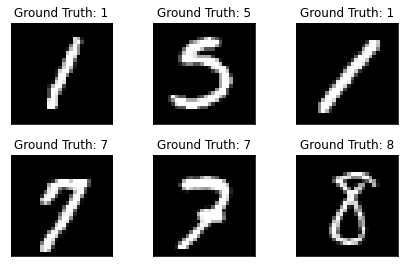

In [25]:
example_data,example_targets = next(iter(train_loader))
import matplotlib.pyplot as plt
fig = plt.figure()

for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
plt.show()

In [26]:
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [27]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet,self).__init__()
        self.conv_1 = nn.Sequential(
            nn.Conv2d(1,32,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.25)
        )
        self.conv_2 = nn.Sequential(
            nn.Conv2d(32,64,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.25),
        )

        self.conv_3 = nn.Sequential(
            nn.Conv2d(64,128,kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.25),
        )

        self.fc = nn.Sequential(
            nn.Linear(512,128),
            nn.Linear(128,10)
        )

    def forward(self,x):
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.conv_3(x)
        x = x.view(x.size(0),-1)
        
        x = self.fc(x)
        return F.log_softmax(x,dim=1)
myNet = MyNet().to(device)
# myNet = torch.load("mnist.h5").to(device)

In [28]:
def test_acc():
    correct = 0
    total = 0
    for data in valid_loader:
        valid_imgs,valid_labels = data
        valid_imgs = valid_imgs.type(torch.FloatTensor)
        outputs = myNet(valid_imgs.to(device)).to("cpu")
        _,predict_label = torch.max(outputs,1)
        total += valid_labels.size(0)
        correct += (predict_label == valid_labels).sum().item()
    return correct/total
    
def train_loss_acc():
    losses = 0
    correct = 0
    total = 0
    for i,data in enumerate(train_loader,0):
        imgs,labels = data
        imgs = imgs.type(torch.FloatTensor)
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = myNet(imgs)
        _,predict_label = torch.max(outputs,1)
        total += labels.size(0)
        correct += (predict_label == labels).sum().item()

        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        losses += loss.item()
    
    return losses,correct/total


In [31]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

log_writer = SummaryWriter()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(myNet.parameters(),lr=0.001,momentum=0.9)

for epoch in range(100,400):
    myNet.train()
    loss,acc = train_loss_acc()
    log_writer.add_scalar("Loss/train",float(loss),epoch)
    log_writer.add_scalar("Acc/train",float(acc),epoch)
    myNet.eval()
    acc = test_acc()
    log_writer.add_scalar("Acc/valid",float(acc),epoch)
        

In [32]:
torch.save(myNet,"mnist.h5")